<a href="https://colab.research.google.com/github/saturnMars/FM_2025/blob/main/Lab2_probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
import pandas as pd
import tarfile

# Getting the labelled datasets for:
- ***binary* classification**:
    1. **Truthfulness** (True/false claims)
        - *[The Geometry of Truth: Emergent Linear Structure in Large Language Model Representations of True/False Datasets](https://github.com/saprmarks/geometry-of-truth/tree/main)*
    2. **Subjectivity** (subjective/objetive sentences)
        - [CLEF 2025, Task 1 - Subjectivity](https://checkthat.gitlab.io/clef2025/task1/)
- ***multiclass* classification**:
    3. **Tense** (past/present/future)
        - [EnglishTense: A large scale English texts dataset categorized into three categories: Past, Present, Future tenses.](https://data.mendeley.com/datasets/jnb2xp9m4r/2)
    4. **Language** (utterances from multiple languages)
        - [MASSIVE: A 1M-Example Multilingual Natural Language Understanding Dataset with 51 Typologically-Diverse Languages](https://github.com/alexa/massive)



### (1) TRUTHFULNESS (The Geometry of Truth; TRUE|FALSE)

In [2]:
truthfulness_df = pd.read_csv("https://raw.githubusercontent.com/saprmarks/geometry-of-truth/refs/heads/main/datasets/counterfact_true_false.csv")

# Data preprocessing
truthfulness_df = truthfulness_df[['statement', 'label']].rename(columns = {'statement':'doc'})
truthfulness_df['label'] = truthfulness_df['label'].map(bool)
truthfulness_df['doc'] = truthfulness_df['doc'].str.rstrip('.')

truthfulness_df.attrs['name'] = 'truth'

### (2) SUBJECTIVITY (CLEF2025; SUB|OBJ)

In [3]:
subjectivity_df = pd.concat([
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/train_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/dev_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/dev_test_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/test_en_labeled.tsv", sep= '\t'),
])
subjectivity_df = subjectivity_df[['sentence', 'label']].rename(columns = {'sentence':'doc'})
subjectivity_df['doc'] = subjectivity_df['doc'].str.rstrip('.')

subjectivity_df.attrs['name'] = 'subj'

### (3) TENSE (EnglishTense; past|present|future)

In [4]:
tense_df = pd.read_excel("https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/28304dc7-a47c-4d83-bdcc-2edc535236d8")
tense_df = tense_df.rename(columns = {'Sentence':'doc', 'Labels':'label'})
tense_df['doc'] = tense_df['doc'].str.rstrip('.')
tense_df.attrs['name'] = 'tense'

# Turnaround to fix a bug in the dataset labels
tense_df['label'] = tense_df['label'].str.upper()

### LANGUAGE (MASSIVE; EN/IT/DE/ES/FR/JA)

In [5]:
filename = "amazon-massive-dataset-1.1.tar.gz"
if not path.exists(filename):
    !wget https://amazon-massive-nlu-dataset.s3.amazonaws.com/amazon-massive-dataset-1.1.tar.gz

In [6]:
dfs = []
with tarfile.open(filename, "r:gz") as tar:
    for lang in ['en-US', 'it-IT', 'de-DE', 'es-ES', 'fr-FR', 'ja-JP']:
      dfs.append(pd.read_json(tar.extractfile(path.join('1.1','data', f'{lang}.jsonl')), lines = True).sample(10000))

language_df = pd.concat(dfs, ignore_index = True)[['utt', 'locale']].rename(columns = {'utt':'doc', 'locale': 'label'})
language_df['doc'] = language_df['doc'].str.rstrip('.')

language_df.attrs['name'] = 'lang'

# Data exploration

In [7]:
# TRUTHFULNESS dataset
print('-' * 30, 'TRUTHFULNESS', '-' * 30)
print(f"CLASSES ({truthfulness_df['label'].nunique()}):", '|'.join(truthfulness_df['label'].map(str).unique()), '\n')
print(truthfulness_df)

# SUBJECTIVITY dataset
print('-' * 30, 'SUBJECTIVITY', '-' * 30)
print(f"CLASSES ({subjectivity_df['label'].nunique()}):", '|'.join(subjectivity_df['label'].unique()), '\n')
print(subjectivity_df)

# TENSE dataset
print('-' * 30, 'TENSE', '-' * 30)
print(f"CLASSES ({tense_df['label'].nunique()}):", '|'.join(tense_df['label'].unique()), '\n')
print(tense_df)

# LANGUAGE dataset
print('-' * 30, 'LANGUAGE', '-' * 30)
print(f"CLASSES ({language_df['label'].nunique()}):", '|'.join(language_df['label'].unique()), '\n')
print(language_df)

------------------------------ TRUTHFULNESS ------------------------------
CLASSES (2): True|False 

                                                     doc  label
0       The mother tongue of Danielle Darrieux is French   True
1      The mother tongue of Danielle Darrieux is English  False
2      The official religion of Edwin of Northumbria ...   True
3      The official religion of Edwin of Northumbria ...  False
4      The mother tongue of Thomas Joannes Stieltjes ...   True
...                                                  ...    ...
31959           Jerusalem of Gold was written in Finnish  False
31960  The language used by Jean-Pierre Dionnet is Fr...   True
31961  The language used by Jean-Pierre Dionnet is Sp...  False
31962                              Subair works as actor   True
31963                           Subair works as composer  False

[31964 rows x 2 columns]
------------------------------ SUBJECTIVITY ------------------------------
CLASSES (2): SUBJ|OBJ 

      

### Select the dataset
1. **Multiclass classification** (EASY: *syntax-based*)
    - tense_df (3 classes: PAST|PRESENT|FUTURE)
    - language_df (6 classes: en|it|de|es|fr|ja')

2. **Binary classification** (HARD: *semantic-based*)
    - truthfulness_df (True|False)
    - subjectivity_df (SUBJ|OBJ)


In [8]:
data = truthfulness_df.sample(10000)

# Load the LLMs and get the embeddings for each document
1. OpenAI's GPT-2
    - openai-community/gpt2
    - openai-community/gpt2-medium
    - openai-community/gpt2-xl
2. EleutherAI's Pythia
    - EleutherAI/pythia-160m
    - EleutherAI/pythia-1.4b
    - EleutherAI/pythia-2.8b
3. MetaAI's Llama (meta-llama/Llama-3.2-1B; meta-llama/Llama-3.2-3B)

In [9]:
llm_name = "openai-community/gpt2"

In [10]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import torch

/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {str(device).upper()}")

Device: CUDA


In [12]:
tokenizer = AutoTokenizer.from_pretrained(llm_name)
llm = AutoModel.from_pretrained(llm_name).to(device)
llm.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

### Compute the LLM embeddings

In [13]:
filename = f"_emb_{path.basename(llm_name).replace('-', '_')}_{data.attrs['name']}.pt"

if path.exists(filename):
    embeddings = torch.load(filename)
    print('Loaded the embeddings from the disk.')
else:

    # Get the unique documents to avoid redundant computations
    docs = data['doc'].drop_duplicates().values

    # Compute the embeddings for each document
    embeddings = dict()
    for doc in tqdm(docs):

        # Tokenize the textual document (x)
        input_ids = tokenizer(doc, return_tensors = 'pt').to(llm.device)

        # Process the tokenized document using the frozen LLM
        llm_output = llm(**input_ids, output_hidden_states=True)

        # Get the embeddings from the last hidden layer [batch_size, seq_len, hidden_dim]
        selected_layer = llm.config.num_hidden_layers // 2 # -1
        last_token_emb = llm_output.hidden_states[selected_layer][:, -1, :]
        embeddings[doc] = last_token_emb.detach().cpu().squeeze()

    # Cache embeddings to save time in future runs
    torch.save(embeddings, filename)

# Add embeddings to the original dataframe
data['embedding'] = data['doc'].map(embeddings)

# Remove samples without embeddings (if any)
data = data.dropna(subset = ['embedding']).reset_index(drop = True)
print(f"Dataset: {data.shape[0]} samples")

Loaded the embeddings from the disk.
Dataset: 3096 samples


## Create our own [*PyTorch Dataset*](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) for training


In [14]:
from torch.utils.data import Dataset

In [15]:
class MyDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

        # Convert the textual labels into numerical classes (e.g., PAST --> 0; PRESENT --> 1; FUTURE --> 2)
        self.class_mapping = {i: label for i, label in enumerate(df['label'].unique())}
        self.label_to_int = {v: k for k, v in self.class_mapping.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        embeddings = self.df.iloc[idx]['embedding']

        labels = self.df.iloc[idx]['label']
        labels = self.label_to_int[self.df.iloc[idx]['label']]

        return embeddings, labels

    def get_embedding_dim(self):
        return self.df.iloc[0]['embedding'].shape[0]

    def get_num_classes(self):
        return len(self.class_mapping)


# Explore the dataset

In [16]:
# Initialize the dataset
dataset = MyDataset(data)

# Explore the dataset
training_items = iter(dataset)
emb_0, label_0 = next(training_items)
print(f"EMBEDDING (X; type: {type(emb_0)}; size = {emb_0.shape[0]})" '--> CLASS (Y):', label_0, f'({dataset.class_mapping[label_0]})')

emb_1, label_1 = next(training_items)
print(f"EMBEDDING (X; type: {type(emb_1)}; size = {emb_1.shape[0]})" '--> CLASS (Y):', label_1, f'({dataset.class_mapping[label_1]})')

EMBEDDING (X; type: <class 'torch.Tensor'>; size = 768)--> CLASS (Y): 0 (True)
EMBEDDING (X; type: <class 'torch.Tensor'>; size = 768)--> CLASS (Y): 1 (False)


## Create our own *DataModule* ([PyTorch Lightining](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)) with *DataLoaders* (PyTorch)

In [17]:
!pip install lightning

In [18]:
from lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split

In [19]:
class MyDataModule(LightningDataModule):
    def __init__(self, data: Dataset, batch_size: int = 32, val_size:float = 0.1, test_size:float = 0.1):
        super().__init__()

        # Initialize the variables
        self.data = data
        self.batch_size = batch_size

        self.train_size = 1 - val_size - test_size
        self.val_size = val_size
        self.test_size = test_size

        # Set the seed for reproducibility
        self.random_seed = 101

    def setup(self, stage:str):

        # Create the splits
        train_set, val_set, test_set = random_split(
            dataset = self.data,
            generator = torch.Generator().manual_seed(self.random_seed),
            lengths = [self.train_size, self.val_size, self.test_size])

        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set

        print('\nINPUTS:', len(self.data), '--> TRAIN:', round(((len(self.train_set) / len(self.data)) * 100), 1), '%',
              '|| VALIDATION:', round(((len(self.val_set) / len(self.data)) * 100), 1), '%',
              '|| TEST:', round(((len(self.test_set) / len(self.data)) * 100), 1), '%', '\n')

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size = self.batch_size, shuffle = True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size = self.batch_size, shuffle = False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size = self.batch_size, shuffle = False)

# Create our probe
### A multiclass classifier that extracts latent features ($y_i \in \mathcal{Y}$; classes) from LLM embeddings
$ \mathcal{F}: \mathbb{R}^d \to \mathcal{Y}, \quad emb_{doc} \to label_{doc}$

In [20]:
import torch.nn as nn

In [21]:
class Network(nn.Module):
    def __init__(self, input_dim:int, num_classes: int):
        super().__init__()

        self.num_classes = num_classes
        self.input_dim = input_dim

        # Set the latent dimension
        self.latent_dim = 512

        # Set the probability for the dropout layer
        self.drop_p = 0.5

        # Encoder layers
        self.decoder_layer = nn.Sequential(
            nn.Linear(self.input_dim, self.latent_dim),
            nn.ReLU(),
            nn.LayerNorm(self.latent_dim),
            nn.Dropout(self.drop_p)
        )

        # Output layers
        self.output_layer = nn.Sequential(
            nn.LayerNorm(self.latent_dim),
            nn.Linear(self.latent_dim, self.num_classes),
            nn.Softmax(dim = 1) # Get probability distribution over the classes [batch_size, num_classes]
        )

    def forward(self, x):

        # Learn the latent fetures from the LLM embeddings
        x = self.decoder_layer(x)

        # Output layer with the SoftMax
        out = self.output_layer(x)

        return out

### Why do we consider the median hidden layer?

# Define the loss function and the training process

In [22]:
from lightning import LightningModule
from torchmetrics.classification import F1Score, Precision, Recall

In [23]:
class Classifier(LightningModule):
    def __init__(self, num_classes: int, input_dim:int, lr:float):
        super().__init__()

        # Unpacked the configs
        self.lr = lr

        # Load our custom model
        self.model = Network(input_dim, num_classes)

        # Define the loss function
        self.loss_function = nn.CrossEntropyLoss()

        # Define the classification metrics for the validation and test sets
        self.val_history = {'F1': [], 'precision': [], 'recall': []}

        # Define the classification metrics for the validation and test sets
        self.val_f1 = F1Score(task="multiclass", num_classes = num_classes, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes = num_classes, average="macro")

        self.val_precision = Precision(task="multiclass", num_classes = num_classes, average="macro")
        self.test_precision = Precision(task="multiclass", num_classes = num_classes, average="macro")

        self.val_recall = Recall(task="multiclass", num_classes = num_classes, average="macro")
        self.test_recall = Recall(task="multiclass", num_classes = num_classes, average="macro")

        self.val_history = {'F1': [], 'precision': [], 'recall': []}

    # Define the optimizer
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr = self.lr)

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, batch_idx):

        # Unpack the batch
        docs, labels = batch

        # Forward pass
        outputs = self(docs)

        # Compute the loss
        loss = self.loss_function(outputs, labels)

        # Get the most likely class
        preds = torch.argmax(outputs, dim=1)

        return loss, preds, labels

    def training_step(self, batch, batch_idx):
        loss, *_  = self._step(batch, batch_idx)

        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.inference_mode():
            loss, preds, labels  = self._step(batch, batch_idx)

        # Compute the classification metrics for the validation set
        self.val_precision.update(preds, labels)
        self.val_recall.update(preds, labels)
        self.val_f1.update(preds, labels)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_precision', self.val_precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_recall', self.val_recall, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_history['precision'].append(self.trainer.callback_metrics["val_precision"].item())
        self.val_history['recall'].append(self.trainer.callback_metrics["val_recall"].item())
        self.val_history['F1'].append(self.trainer.callback_metrics["val_f1"].item())

        # Visualize the metrics every two epochs
        if (self.current_epoch + 1) % 2 == 0:
            df = pd.DataFrame(self.val_history)
            plot_values(df, epoch_number = self.current_epoch + 1)

    def test_step(self, batch, batch_idx):
        with torch.inference_mode():
            _, preds, labels  = self._step(batch, batch_idx)

        # Compute the classification metrics for the test set
        self.test_precision.update(preds, labels)
        self.test_recall.update(preds, labels)
        self.test_f1.update(preds, labels)

        # Log metrics
        self.log('test_precision', self.test_precision, on_epoch=True, prog_bar=True)
        self.log('test_recall', self.test_recall, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.test_f1, on_epoch=True, prog_bar=True)


### Create the plot the visualize the metrics during training

In [24]:
!pip install seaborn

In [25]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def plot_values(df, epoch_number):
    colors = {'F1': 'tab:blue', 'precision': 'tab:green', 'recall': 'tab:orange'}

    # Plot the metrics as lines
    sns.lineplot(data = df, palette = colors, marker = 'o')

    # Some graphical setting
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'VALIDATION (epoch {epoch_number})')
    ax.grid(True)
    ax.legend(title="Metric")

    plt.show()

# Train our custom neural models with Pytorch Lighting

In [27]:
num_epochs = 10
learning_rate = 1e-4

In [28]:
probe = Classifier(
    num_classes = dataset.get_num_classes(),
    input_dim = dataset.get_embedding_dim(),
    lr = learning_rate)
dataloaders = MyDataModule(dataset, batch_size = 32, val_size = 0.1, test_size = 0.1)

In [29]:
from lightning import Trainer

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, u


INPUTS: 3096 --> TRAIN: 80.0 % || VALIDATION: 10.0 % || TEST: 10.0 % 




  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | Network             | 396 K  | train
1 | loss_function  | CrossEntropyLoss    | 0      | train
2 | val_f1         | MulticlassF1Score   | 0      | train
3 | test_f1        | MulticlassF1Score   | 0      | train
4 | val_precision  | MulticlassPrecision | 0      | train
5 | test_precision | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
7 | test_recall    | MulticlassRecall    | 0      | train
---------------------------------------------------------------
396 K     Trainable params
0         Non-trainable params
396 K     Total params
1.587     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 78/78 [00:00<00:00, 322.83it/s, v_num=29, val_loss=0.664, val_precision=0.624, val_recall=0.623, val_f1=0.622, train_loss=0.698]

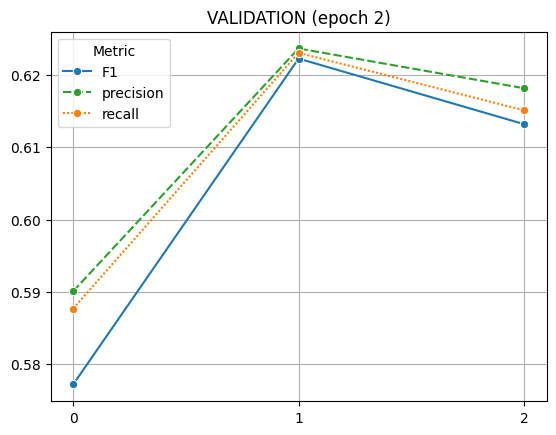

Epoch 3: 100%|██████████| 78/78 [00:00<00:00, 328.13it/s, v_num=29, val_loss=0.654, val_precision=0.595, val_recall=0.589, val_f1=0.582, train_loss=0.641]

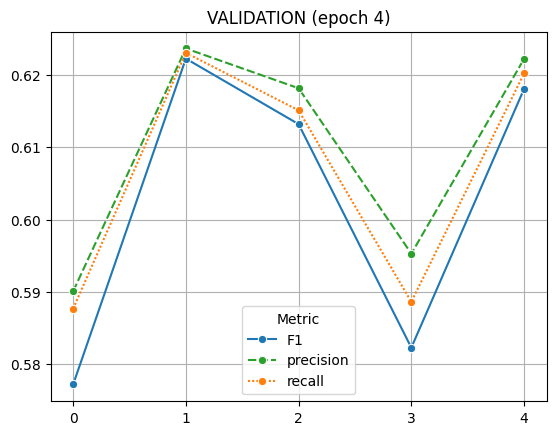

Epoch 5: 100%|██████████| 78/78 [00:00<00:00, 322.63it/s, v_num=29, val_loss=0.656, val_precision=0.613, val_recall=0.613, val_f1=0.613, train_loss=0.621]

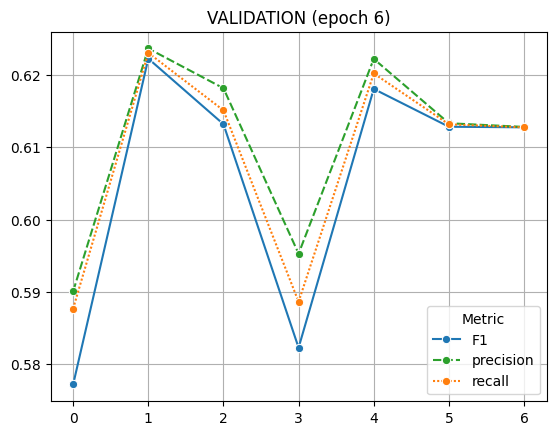

Epoch 7: 100%|██████████| 78/78 [00:00<00:00, 333.06it/s, v_num=29, val_loss=0.668, val_precision=0.597, val_recall=0.596, val_f1=0.596, train_loss=0.603]

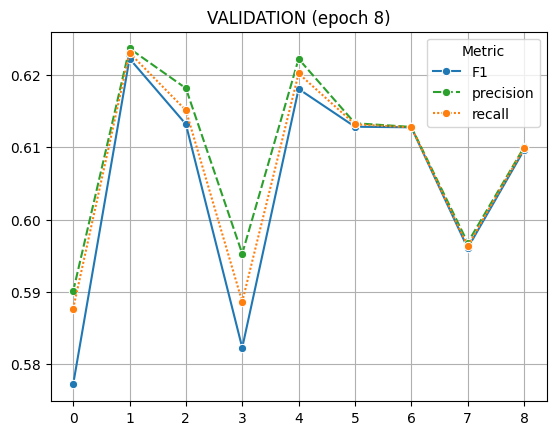

Epoch 9: 100%|██████████| 78/78 [00:00<00:00, 332.14it/s, v_num=29, val_loss=0.673, val_precision=0.628, val_recall=0.621, val_f1=0.615, train_loss=0.586]

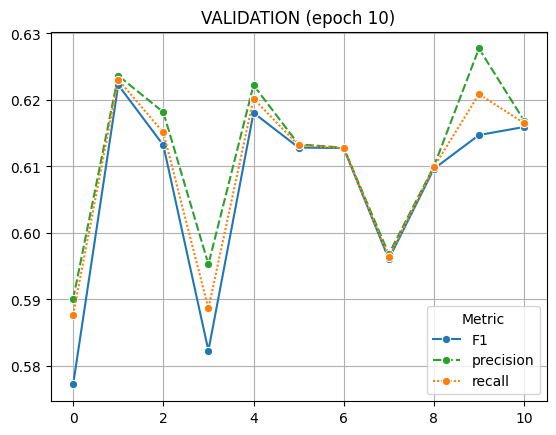

Epoch 9: 100%|██████████| 78/78 [00:00<00:00, 219.00it/s, v_num=29, val_loss=0.669, val_precision=0.617, val_recall=0.617, val_f1=0.616, train_loss=0.582]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 78/78 [00:00<00:00, 212.69it/s, v_num=29, val_loss=0.669, val_precision=0.617, val_recall=0.617, val_f1=0.616, train_loss=0.582]


In [30]:
trainer = Trainer(max_epochs = num_epochs)
trainer.fit(probe, datamodule=dataloaders)

# Compute metrics on the test set

In [31]:
test_metrics = trainer.test(model = probe, datamodule=dataloaders)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



INPUTS: 3096 --> TRAIN: 80.0 % || VALIDATION: 10.0 % || TEST: 10.0 % 



/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 201.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.6213433742523193
     test_precision         0.6216267347335815
       test_recall          0.6216981410980225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [32]:
import json
with open(f"metrics.json", mode = "a+") as f:
    json.dump({data.attrs['name']: test_metrics}, f, indent=4)

# Test with out-of-distribution documents

In [33]:
lang_docs = [
    'Life is full of surprises', # English (en)
    'La vita è piena di sorprese', # Italian (it)
    'as Leben ist voller Überraschungen', # German (de)
    'La vida está llena de sorpresas', # Spanish (es)
    'La vie est pleine de surprises', # French (fr)
    '人生は驚きに満ちている' # Japanese (ja)
]

# Add tricky samples (italian sentences with some english words)
lang_docs.append("Se non deliveriamo the project by next week, saremmo in big problems")
lang_docs.append("If non deliveriamo the project by next week, saremmo in big problems")

In [34]:
tense_docs = [
    'I will go to the store tomorrow', # FUTURE
    'She is reading a book', # PRESENT
    'They played soccer last weekend', # PAST
    'We are going to the park later', # PRESENT
    'He will finish his homework tonight', # FUTURE
    'I walked to school yesterday' # PAST
]

In [35]:
truthfulness_docs = ['The earth is flat', 'Water boils at 100 degrees Celsius', 'The sky is green', 'The sky is blue', 'Renault 8 is produced by Fiat']

In [36]:
if data.attrs['name'] == 'lang':
    docs = lang_docs
elif data.attrs['name'] == 'tense':
    docs = tense_docs
elif data.attrs['name'] == 'truth':
    docs = truthfulness_docs

### Initialize the language models and our trained probe

In [37]:
# Initialize the tokenizer and the LLM
tokenizer = AutoTokenizer.from_pretrained(llm_name)
llm = AutoModel.from_pretrained(llm_name).to(device)
llm.eval()

# Turn the trained model to evaluation mode
probe.eval()

Classifier(
  (model): Network(
    (decoder_layer): Sequential(
      (0): Linear(in_features=768, out_features=512, bias=True)
      (1): ReLU()
      (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.5, inplace=False)
    )
    (output_layer): Sequential(
      (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=512, out_features=2, bias=True)
      (2): Softmax(dim=1)
    )
  )
  (loss_function): CrossEntropyLoss()
  (val_f1): MulticlassF1Score()
  (test_f1): MulticlassF1Score()
  (val_precision): MulticlassPrecision()
  (test_precision): MulticlassPrecision()
  (val_recall): MulticlassRecall()
  (test_recall): MulticlassRecall()
)

### Apply the probe on the documents
1. Get the embeddings for the document using the LLM
2. Feed the embeddings into the trained probe
3. Get the predicted classes

In [38]:
# Apply the trained model to external data
with torch.inference_mode():

    # Get the embeddings for the new documents
    embeddings = list()
    for doc in docs:

        # Tokenize the textual document (x)
        input_ids = tokenizer(doc, return_tensors = 'pt').to(llm.device)

        # Process the tokenized document using the frozen LLM
        llm_output = llm(**input_ids, output_hidden_states=True)

        # Get the embeddings from the last hidden layer [batch_size, seq_len, hidden_dim]
        selected_layer = llm.config.num_hidden_layers // 2 # -1
        embedding = llm_output.hidden_states[selected_layer][:, -1, :].detach().cpu().squeeze()
        embeddings.append(embedding)

    # Stack the embeddings into a single tensor
    embeddings = torch.stack(embeddings)

    # Get the outputs from the trained probe
    outputs = probe(embeddings)

# Get the predicted labels
preds = torch.argmax(outputs, dim=1)
predicted_labels = [dataset.class_mapping[pred.item()] for pred in preds]

# Show the predictions
for doc, predicted_label, scores in zip(docs, predicted_labels, outputs):
    pred_score = torch.max(scores).item()
    print(doc, '-->', predicted_label, f"({pred_score:.2f})")

The earth is flat --> False (0.65)
Water boils at 100 degrees Celsius --> False (0.96)
The sky is green --> False (0.95)
The sky is blue --> False (0.78)
Renault 8 is produced by Fiat --> False (0.95)
